# What's about?
### This script gets 2D plots with domain "day vs time" by using s4 values from many days for all constelations and frequencies 

In [150]:
import septentrio_tools2 as st
import pandas as pd
import numpy as np
import datetime
import time 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.backends.backend_pdf import PdfPages
import glob 

In [42]:
start = time.time()

### 1. Merge s4 dataframes from many days

In [43]:
def process_df(input_file):
    h = st.ProcessISMR()
    # Read and normalize 
    h.read_file(input_file)
    h.normalize_df()
    # Rename the Elev column
    columnas = ["Elev", "S4_sig1", "S4_sig1_corr", "S4_sig2", "S4_sig2_corr", "S4_sig3", "S4_sig3_corr"]
    h.rename_column(5, columnas[0])
    # Rename the s4 columns
    h.rename_column(7, columnas[1])
    h.rename_column(8, columnas[2])
    h.rename_column(32, columnas[3])
    h.rename_column(33, columnas[4])
    h.rename_column(46, columnas[5])
    h.rename_column(47, columnas[6])
    # Extract certain columns 
    h.extract_columns(cols=columnas)
    # Convert to float 
    h.convert2float(cols=columnas)
    # Assign the df 
    df2 = h.df
    # Calculate the corrected S4
    def get_correctedS4(row):
        s4 = row[0]
        correction= row[1]

        # Treat nan numbers 
        if pd.isnull(s4) or pd.isnull(correction):
            return np.nan
        else:
            # Calculate the corrected S4
            x = s4**2-correction**2
            if x>0:
                return x**0.5
            else:
                return 0    

    for i in range(3):        
        # calculate
        df2[f"S4_sig{i+1}"] = df2[[f"S4_sig{i+1}",f"S4_sig{i+1}_corr"]].apply(get_correctedS4, axis=1)
        # delete
        del df2[f"S4_sig{i+1}_corr"]
        
    return df2  

In [44]:
path_src = "/home/luis/Desktop/Proyects_Files/LISN/GPSs/Tareas/Plot_s4_2D/Input_data/Data_set/"

In [45]:
list_files = glob.glob(path_src + "*.ismr")
list_files = sorted(list_files, key=lambda x: (x[-8:-6], x[-17:-9])) # sort by year first, then by doy  
j = 0
if len(list_files) > 0:
    for file in list_files:
        df1 = process_df(file)
        if j == 0:
            df2 = df1
        else:
            # Merge dfs
            df2 = df2.append(other=df1)
        j += 1       
df3 = df2
df3.head()

,PRN,Elev,S4_sig1,S4_sig2,S4_sig3
DateTime,,,,,
2020-09-26 00:01:00,G10,72.0,0.000000,0.021633,0.0
2020-09-26 00:01:00,G16,49.0,0.064062,NaN,NaN
2020-09-26 00:01:00,G20,40.0,0.098590,NaN,NaN
2020-09-26 00:01:00,G21,33.0,0.083720,NaN,NaN
2020-09-26 00:01:00,G26,83.0,0.000000,0.000000,0.0


In [46]:
# Extract the available dates 
#np.unique(df3.index.date)

array([datetime.date(2020, 9, 26), datetime.date(2020, 9, 27),
       datetime.date(2020, 9, 28), datetime.date(2020, 10, 6),
       datetime.date(2020, 10, 7), datetime.date(2020, 10, 8),
       datetime.date(2020, 10, 9), datetime.date(2020, 10, 10),
       datetime.date(2020, 10, 11), datetime.date(2020, 10, 12),
       datetime.date(2020, 10, 13), datetime.date(2020, 10, 14),
       datetime.date(2020, 10, 15), datetime.date(2020, 10, 16),
       datetime.date(2020, 11, 17), datetime.date(2020, 11, 18),
       datetime.date(2020, 11, 19), datetime.date(2020, 11, 20),
       datetime.date(2020, 11, 21), datetime.date(2020, 11, 22),
       datetime.date(2020, 11, 23), datetime.date(2020, 11, 24),
       datetime.date(2020, 11, 25), datetime.date(2020, 11, 26),
       datetime.date(2020, 11, 27), datetime.date(2020, 11, 28),
       datetime.date(2020, 11, 29), datetime.date(2020, 11, 30),
       datetime.date(2020, 12, 1), datetime.date(2020, 12, 2),
       datetime.date(2020, 12, 3),

## Plot for many PRNs

### 1. Initialize plot object 

In [149]:
m = st.PlotsISMR(dataframe=df3, ismr_file_name="ljic2800.20_.ismr")

In [115]:
# Plot the available prns
PRNs = m.extract_prns(const='G', freq='S4_sig1')
PRNs

['G1',
 'G2',
 'G3',
 'G4',
 'G5',
 'G6',
 'G7',
 'G8',
 'G9',
 'G10',
 'G11',
 'G12',
 'G13',
 'G14',
 'G15',
 'G16',
 'G17',
 'G18',
 'G19',
 'G20',
 'G21',
 'G22',
 'G23',
 'G24',
 'G25',
 'G26',
 'G27',
 'G28',
 'G29',
 'G30',
 'G31',
 'G32']

In [118]:
# Get the min and max date values 
dates_limits = m.minMax_dates()
minDate = dates_limits["minDate"]
maxDate = dates_limits["maxDate"]
minDate, maxDate

(Timestamp('2020-09-26 00:01:00'), Timestamp('2021-01-31 00:00:00'))

In [119]:
minDate.year

2020

In [143]:
datetime.datetime.today()

datetime.datetime(2021, 4, 9, 13, 11, 8, 34185)

### 2. Create 2D array 

In [135]:
def create2D_array(s): # pandas serie
    # Complete boundaries values for index variable (datetime)
    # -> Lower value of range
    val1 = minDate #s.index[0]
    val1_comp = datetime.datetime(val1.year, val1.month, val1.day, 0, 0)
    if val1 != val1_comp:
        s_aux1 = pd.concat([pd.Series([np.nan]), s])
        s_aux1 = s_aux1.rename({0:val1_comp})
    else:
        s_aux1 = s

    # -> Upper value of range
    val2 = maxDate #s.index[-1]
    val2_comp = datetime.datetime(val2.year, val2.month, val2.day, 23, 59) + datetime.timedelta(minutes=1)
    if val2 != val2_comp:
        s_aux2 = pd.concat([s_aux1, pd.Series([np.nan])])
        s_aux2 = s_aux2.rename({0:val2_comp})
    else:
        s_aux2 = s_aux1
        
    # Resampling 
    s2 = s_aux2.resample("T").asfreq() # Each minute 

    # Forming the 2D array 
    fechas = np.unique(s2.index.date)

    j=0
    for fecha in fechas:
        ind = fecha.strftime("%Y-%m-%d")
        serie = s2.loc[ind]
        values = serie.values
        if len(values) > 1:
            if j==0: 
                s4_array = [values]  
            else:
                s4_array = np.append(s4_array, [values], axis=0)
        j += 1

    s4_array = s4_array.T
    
    return {"fechas": fechas, "s4_array": s4_array}    

In [136]:
60*24

1440

In [147]:
# Test for a single prn 
s1 = m.get_variable(prn="G20", var='S4_sig1')
create2D_array(s1)

{'fechas': array([datetime.date(2020, 9, 26), datetime.date(2020, 9, 27),
        datetime.date(2020, 9, 28), datetime.date(2020, 9, 29),
        datetime.date(2020, 9, 30), datetime.date(2020, 10, 1),
        datetime.date(2020, 10, 2), datetime.date(2020, 10, 3),
        datetime.date(2020, 10, 4), datetime.date(2020, 10, 5),
        datetime.date(2020, 10, 6), datetime.date(2020, 10, 7),
        datetime.date(2020, 10, 8), datetime.date(2020, 10, 9),
        datetime.date(2020, 10, 10), datetime.date(2020, 10, 11),
        datetime.date(2020, 10, 12), datetime.date(2020, 10, 13),
        datetime.date(2020, 10, 14), datetime.date(2020, 10, 15),
        datetime.date(2020, 10, 16), datetime.date(2020, 10, 17),
        datetime.date(2020, 10, 18), datetime.date(2020, 10, 19),
        datetime.date(2020, 10, 20), datetime.date(2020, 10, 21),
        datetime.date(2020, 10, 22), datetime.date(2020, 10, 23),
        datetime.date(2020, 10, 24), datetime.date(2020, 10, 25),
        dateti

### ANALYSIS

In [138]:
minDate, maxDate

(Timestamp('2020-09-26 00:01:00'), Timestamp('2021-01-31 00:00:00'))

In [ ]:
minDate.date

### 3. Plot s4 values

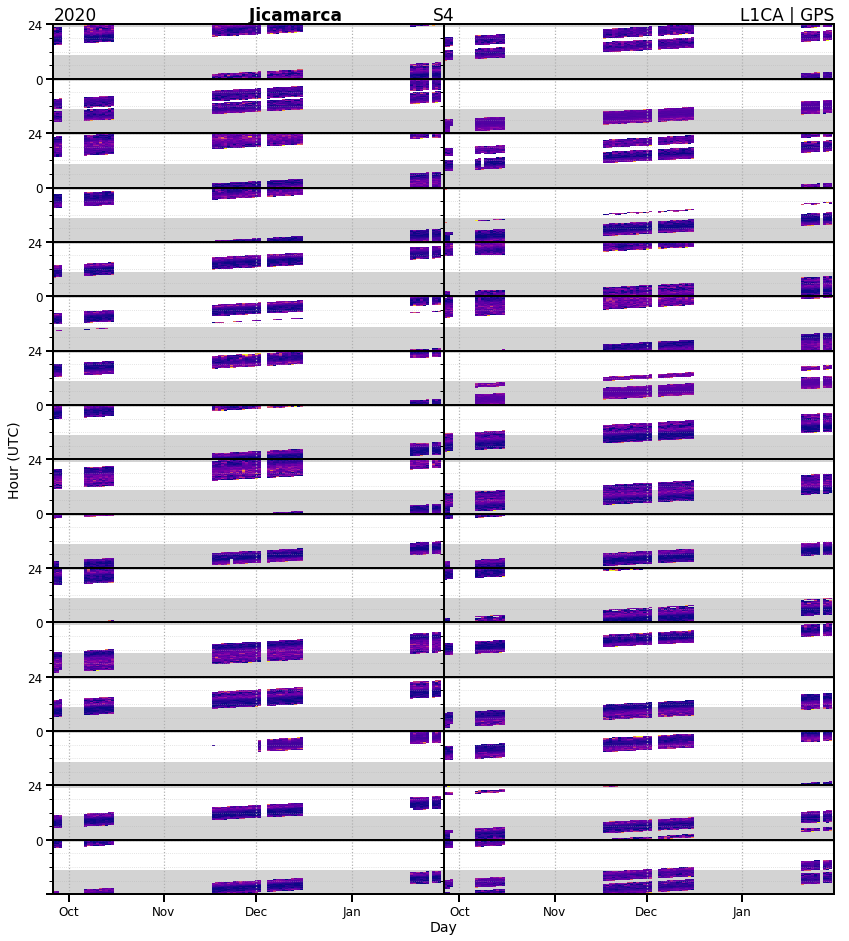

In [144]:
# Calculate x, y limits 
# -> x boundaries (dates)
x_lims=[minDate, maxDate]
# -> y boundaries (time)[0-24h]
#yo = datetime.datetime(fechas[0].year, fechas[0].month, fechas[0].day, 0, 0)
y_lims= [maxDate, maxDate + datetime.timedelta(days=1)]

# Change x,y datetime to numeric values
x_lims = mdates.date2num(x_lims)
y_lims = mdates.date2num(y_lims)

# Strip morning/night
fecha_morning_first = maxDate + pd.DateOffset(hours=11) 
fecha_morning_first = fecha_morning_first.to_pydatetime()
fecha_morning_last = maxDate + pd.DateOffset(hours=23)
fecha_morning_last = fecha_morning_last.to_pydatetime()

# PLOT
# Create the figure with the subplots 
n_rows = (len(PRNs)+1)//2
n_cols = 2

cmap = "plasma"
fig, axs = plt.subplots(n_rows, n_cols, figsize=(7*n_cols,1*n_rows), sharex="col", sharey="row",
                gridspec_kw={'hspace': 0, 'wspace': 0})   
j=0
for ax in axs.T.reshape(-1):
    # Get s4 data
    s = m.get_variable(prn=PRNs[j], var='S4_sig1')
    s_aux = create2D_array(s)
    s4_array = s_aux["s4_array"]

    # Plot
    im = ax.imshow(s4_array, cmap=cmap, extent=[x_lims[0], x_lims[1],  y_lims[0], y_lims[1]], aspect = 'auto', vmin=0, vmax=0.5)
    #ax.set(xlabel="Day", ylabel="Hour (UTC)", title="S4")
    ax.xaxis_date()
    ax.yaxis_date()
    
    # Horizontal morning/night strip 
    ax.set_facecolor(color="lightgrey")
    ax.axhspan(fecha_morning_first, fecha_morning_last, color="white", zorder=0) # strip morning/night, and send to back 
    
    # Set x axis ticks and labels 
    ax.xaxis.set_major_locator(mdates.DayLocator(1)) # First day every month 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))#('%b'))
    #ax.yaxis.set_major_formatter(mdates.DateFormatter('%H'))
    
    # Set ticks and tick labels 
    # Set y axis format, labels odds subplots only
    #color1 = "blue"
    #color2 = "orange"
    len_half_ax = len(axs.T.reshape(-1))/2

    if j >= len_half_ax: # change only for the 2nd column
        k=j-len_half_ax

        # Set y labels only to even subplots
        ax.yaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax.yaxis.set_minor_locator(AutoMinorLocator(4))
        ax.set_yticks([y_lims[0],y_lims[1]])
        
        if k%2 == 0: 
            ax.set_yticklabels([0,24])
        else:    
            ax.set_yticklabels(['',''])
        
        # Set yellow color to the right y axis
        for axis in ['top','bottom','left', 'right']:
            ax.spines[axis].set_linewidth(2)

        #ax.spines['right'].set_color(color2)
        #ax.spines['right'].set_linewidth(2)

    else: # apply some changes to the 1st column 

        # set linewidth to top, bottom and right borders of the subplot
        for axis in ['top','bottom','right', 'left']:
            ax.spines[axis].set_linewidth(2)

        # Set blue color to the left y axis
        #ax.spines['left'].set_color(color1)
        #ax.spines['left'].set_linewidth(2)
        #ax.tick_params(axis='y', which='both', colors=color1)

    # set the ticks style 
    ax.xaxis.set_tick_params(width=2, length=8, which='major', direction='out')
    ax.xaxis.set_tick_params(width=1, length=4, which='minor', direction='out')
    ax.yaxis.set_tick_params(width=2, length=15, which='major', direction='inout')
    ax.yaxis.set_tick_params(width=1, length=4, which='minor', direction='out')
    
    # set the label ticks 
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # set grid
    ax.grid(which='major', axis='both', ls=':', linewidth=1.2)
    ax.grid(which='minor', axis='both', ls=':', alpha=0.5)

    # Set title and axis labels 
    # -> Title 
    if j == 0: # Subplot on Upper left  
        fig.text(0, 1, "2020", ha='left', va='bottom', fontsize=17, weight='roman', transform=ax.transAxes)
        fig.text(0.5, 1, 'Jicamarca', ha='left', va='bottom', fontsize=17, weight='semibold', transform=ax.transAxes)   

    if j == n_rows-1: # Subplot on Lower left 
        pass

    if j == n_rows: # Subplot on Upper right
        fig.text(0, 1, 'S4', ha='center', va='bottom', fontsize=17, weight='roman', transform=ax.transAxes)
        #fig.text(0.5, 1, frequency_value, ha='center', va='bottom', fontsize=17, weight='roman', transform=ax.transAxes)
        fig.text(1, 1, "L1CA | GPS", ha='right', va='bottom', fontsize=17, weight='roman', transform=ax.transAxes)

    # -> Axis labels            
    if j == n_rows*n_cols-1: # Subplot on Lower right, x axis label 
        fig.text(0, -0.6, 'Day', ha='center', va='center', fontsize=14, transform=ax.transAxes) 

    if j == int(n_rows/2): # y axis label on the left
        k = (n_rows%2)*0.5
        fig.text(-0.1, 1-k, 'Hour (UTC)', ha='center', va='center', rotation='vertical', fontsize=14, transform=ax.transAxes)            

    j += 1  

In [ ]:
end = time.time()
print(f"Executing time: {end - start}s")

### Plot 2  